In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import datetime
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers


In [11]:
warnings.filterwarnings("ignore")

In [22]:
JPM = yf.Ticker('JPM')
JPM = JPM.history(start='2015-01-01',end='2020-12-31')
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000,1511.0
mean,82.206896,82.968893,81.445765,82.205533,1.551853e+07,0.009887,0.0
std,22.829643,23.042575,22.634188,22.824209,6.771181e+06,0.081388,0.0
min,44.681966,45.383556,41.570070,44.559078,3.324300e+06,0.000000,0.0
25%,56.433764,56.713373,56.017183,56.434137,1.114535e+07,0.000000,0.0
50%,86.894203,88.044224,85.913343,86.872887,1.377760e+07,0.000000,0.0
75%,99.336537,100.329634,98.336740,99.256760,1.772140e+07,0.000000,0.0
max,129.942660,131.580804,129.348252,131.048004,5.619230e+07,0.900000,0.0


In [23]:
# Elimino la colonna 'Stock Splits', poichè è una colonna contenente tutti zeri, è aggiungo la colonna relativa ai rendimenti del titolo
# che serve soltanto per l'analisi esplorativa
JPM = JPM.drop('Stock Splits', axis = 1)
JPM['Rendimenti'] = JPM['Open'].diff()
JPM.describe()

,Open,High,Low,Close,Volume,Dividends,Rendimenti
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000,1510.000000
mean,82.206896,82.968893,81.445765,82.205533,1.551853e+07,0.009887,0.045864
std,22.829643,23.042575,22.634188,22.824209,6.771181e+06,0.081388,1.505813
min,44.681966,45.383556,41.570070,44.559078,3.324300e+06,0.000000,-10.086378
25%,56.433764,56.713373,56.017183,56.434137,1.114535e+07,0.000000,-0.568298
50%,86.894203,88.044224,85.913343,86.872887,1.377760e+07,0.000000,0.064532
75%,99.336537,100.329634,98.336740,99.256760,1.772140e+07,0.000000,0.678116
max,129.942660,131.580804,129.348252,131.048004,5.619230e+07,0.900000,10.493408


ANALISI ESPLORATIVA:


Verrà effettuata un'analisi esplorativa sia grafica sull'andamento dei prezzi di apertura e dei rendimenti del titolo, sia volta a studiare la forza della correlazione serialedi ogni titolo ed eventuale presenza di cointegrazione fra i titoli.

In [61]:
neg = JPM['Rendimenti']>=0
fig = plt.figure(figsize=(8,5))
gs = fig.add_gridspec(2, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)
fig.suptitle('JPM Stock Price Series')
axs[0].plot(JPM['Open'])
axs[1].plot(JPM['Rendimenti'][neg==True], color = "green")
axs[1].plot(JPM['Rendimenti'][neg==False], color = "red")
axs[1].axhline(y=0.045864, color = "black", linestyle="solid")
axs[1].set_xlabel("Data")
axs[1].set_ylabel("Returns")
axs[0].set_ylabel("Open Price")
for ax in axs.flat:
    ax.label_outer()

# la serie mostra un forte trend, e una volatilità crescente con un cluster abbastanza corposo nell'ultimo periodo.


KeyError: 'Rendimenti'

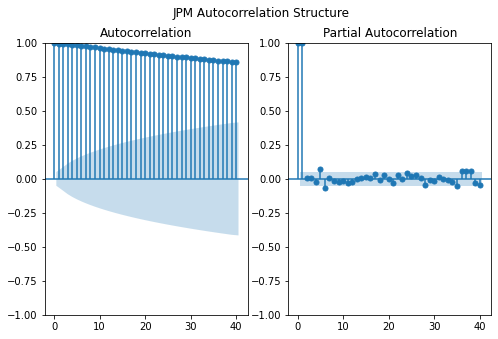

In [6]:
# ACF E PACF della serie; utile anche a capire l'ordine del modello ARIMA
fig, ax = plt.subplots(1, 2, figsize=(8,5))
plot_acf(JPM['Open'], lags=40, ax=ax[0])
plot_pacf(JPM['Open'], lags=40, ax=ax[1])
plt.suptitle("JPM Autocorrelation Structure")
plt.show()

MODELLAZIONE ARIMA



In [26]:
# creazione del train e del test set

filter_row = JPM.index.to_series().between('2015-01-01', '2019-12-31')
test_set = JPM[filter_row == False]
training_set = JPM[filter_row==True]
mc = MinMaxScaler(feature_range=(0,1))
training_set_scaled= mc.fit_transform(training_set[['Open']].values)

In [62]:
test_set.head()

,Open,High,Low,Close,Volume,Dividends
Date,,,,,,
2014-12-31,51.536594,51.691287,50.950397,50.950397,18529400,0.0
2020-01-02,129.840528,131.057301,129.348252,131.048004,10803700,0.0
2020-01-03,128.533385,130.150564,128.140775,129.318604,10386800,0.9
2020-01-06,127.654695,129.253189,127.598610,129.215790,10259000,0.0
2020-01-07,128.327741,128.869920,126.962958,127.019043,10531300,0.0


In [45]:
modello_AAPL = ARIMA(train, order = (2,1,0)).fit()
modello_AAPL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Open   No. Observations:                  252
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -272.079
Date:                Sun, 19 Jun 2022   AIC                            550.158
Time:                        14:45:15   BIC                            560.734
Sample:                             0   HQIC                           554.414
                                - 252                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0418      0.066      0.631      0.528      -0.088       0.172
ar.L2          0.0005      0.065      0.008      0.994      -0.128       0.129
sigma2         0.5117      0.036     14.239      0.000       0.441       0.582
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):                37.16
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.33   Skew:                            -0.37
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

MSE: 30.792342834223025


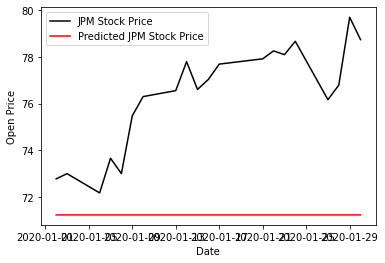

In [46]:
# MSE
yhat_AAPL = modello_AAPL.forecast(steps=20)
MSE_AAPL=mean_squared_error(test, yhat_AAPL)
print("MSE:",MSE_AAPL)
yhat_AAPL.index = test.index
plt.plot(test, color = "black", label = "JPM Stock Price")
plt.plot(yhat_AAPL, color = "red", label = "Predicted JPM Stock Price")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.show()

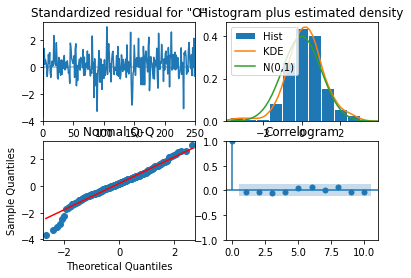

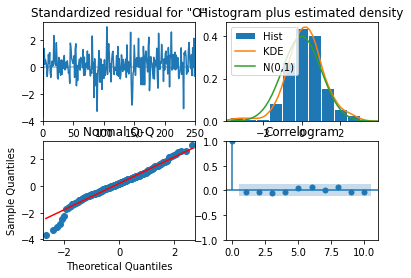

In [47]:
modello_AAPL.plot_diagnostics()

5.19187725493122


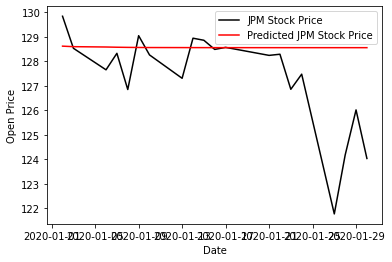

In [49]:
yhat_JPM = modello_JPM.forecast(steps=20)
MSE_JPM=mean_squared_error(test, yhat_JPM)
print(MSE_JPM)
yhat_JPM.index = test.index
plt.plot(test, color = "black", label = "JPM Stock Price")
plt.plot(yhat_JPM, color = "red", label = "Predicted JPM Stock Price")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Open Price")
plt.show()

CONVOLUTIONAL NEURAL NETWORK

In [37]:
# Costruzione del set di training per la multi-step walk forward validation con finestra temporale di 5 giorni
X_train = []
y_train = []
temp = 5
for i in range(temp, training_set.shape[0]):
  X_train.append(training_set_scaled[i-temp:i])
  y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(1253, 5, 1)
(1253, 1)


In [ ]:
print(test_set.shape)

In [54]:
 # Costruzione del set di test per la multi step walk forward validation, con finestra temporale di 5 giorni
dataset_total = pd.concat((training_set['Open'], test_set['Open']), axis = 0)
inputs = dataset_total[len(training_set) - len(test_set) - temp:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = mc.transform(inputs)
X_test = []
for i in range(temp, inputs.shape[0]):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(511,)
(506, 5, 1)


In [70]:
model_5_CNN = keras.Sequential(
    [
     keras.Input(shape=(5,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu'),
     #layers.Dropout(0.1),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(5, activation = "relu")
    ]
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 4, 64)             192       
                                                                 
 dropout (Dropout)           (None, 4, 64)             0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 32)                4128      
                                                                 
 dense_13 (Dense)            (None, 5)                 165       
                                                      

In [71]:
batch_size = 4
epochs = 20
model_5_CNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_5_CNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20


ValueError: in user code:

    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ASUS\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 5, 1), found shape=(4, 10, 1)


In [58]:
# valutazione previsiva per la prima settimana out-of-sample

score= model.evaluate(X_test)

16/16 [==============================] - 0s 997us/step - loss: 0.0000e+00 - MSE: 0.0000e+00


In [60]:
test_set['Open']

Date
2014-12-31     51.536594
2020-01-02    129.840528
2020-01-03    128.533385
2020-01-06    127.654695
2020-01-07    128.327741
                 ...    
2020-12-23    118.182580
2020-12-24    120.406071
2020-12-28    121.108743
2020-12-29    121.474515
2020-12-30    120.791107
Name: Open, Length: 253, dtype: float64

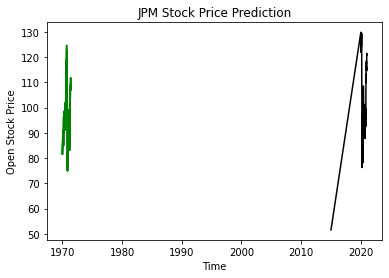

In [68]:
# previsioni del titolo
predicted_stock_price = model.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
plt.plot(test_set['Open'], color = 'black', label = 'JPM Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted jpm Stock Price - 5 days')
plt.title('JPM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Open Stock Price')
#plt.legend()
plt.show()

In [69]:
# usiamo una finestra temporale di due settimane
X_train = []
y_train = []
temp = 10
for i in range(temp, training_set.shape[0]):
  X_train.append(training_set_scaled[i-temp:i])
  y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
dataset_total = pd.concat((training_set['Open'], test_set['Open']), axis = 0)
inputs = dataset_total[len(training_set) - len(test_set) - temp:].values
print(inputs.shape)
inputs = inputs.reshape(-1,1)
inputs = mc.transform(inputs)
X_test = []
for i in range(temp, inputs.shape[0]):
  X_test.append(inputs[i-temp:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(516,)
(506, 10, 1)


In [73]:
model_10_CNN = keras.Sequential(
    [
     keras.Input(shape=(10,1)),
     layers.Conv1D(64, kernel_size = 2,activation='relu'),
     #layers.Dropout(0.1),
     layers.MaxPooling1D(pool_size = 2),
     layers.Flatten(),
     layers.Dense(32, activation="relu"),
     layers.Dense(10, activation = "relu")
    ]
)
model_10_CNN.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 9, 64)             192       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 256)               0         
                                                                 
 dense_18 (Dense)            (None, 32)                8224      
                                                                 
 dense_19 (Dense)            (None, 10)                330       
                                                                 
Total params: 8,746
Trainable params: 8,746
Non-trainable params: 0
____________________________________________________

In [74]:
batch_size = 4
epochs = 20
model_10_CNN.compile(loss=keras.losses.mean_squared_error, optimizer="adam", metrics=[['MSE']])
model_10_CNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/20
312/312 [==============================] - 1s 1ms/step - loss: 0.0496 - MSE: 0.0496
Epoch 2/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0233 - MSE: 0.0233
Epoch 3/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0233 - MSE: 0.0233
Epoch 4/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0233 - MSE: 0.0233
Epoch 5/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0233 - MSE: 0.0233
Epoch 6/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0232 - MSE: 0.0232
Epoch 7/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0232 - MSE: 0.0232
Epoch 8/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0232 - MSE: 0.0232
Epoch 9/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0232 - MSE: 0.0232
Epoch 10/20
312/312 [==============================] - 0s 1ms/step - loss: 0.0232 - MSE: 0.0232
Epoch 11/20
312/312 [============================

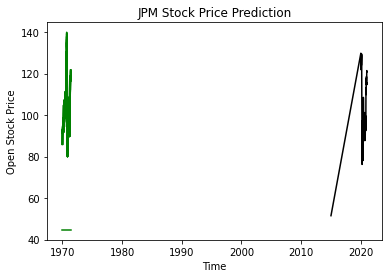

In [75]:
# previsioni del titolo
predicted_stock_price = model_10_CNN.predict(X_test)
predicted_stock_price = mc.inverse_transform(predicted_stock_price)
plt.plot(test_set['Open'], color = 'black', label = 'JPM Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted jpm Stock Price - 5 days')
plt.title('JPM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Open Stock Price')
#plt.legend()
plt.show()

In [76]:
predicted_stock_price

array([[ 85.98212 ,  86.31778 ,  44.681965, ...,  85.959114,  85.85162 ,
         86.06537 ],
       [ 88.20231 ,  88.18235 ,  44.681965, ...,  88.02045 ,  87.9476  ,
         87.94542 ],
       [ 89.1346  ,  88.84079 ,  44.681965, ...,  88.990524,  88.71934 ,
         88.61677 ],
       ...,
       [119.49258 , 119.40489 ,  44.681965, ..., 119.31537 , 119.10601 ,
        119.47016 ],
       [120.624   , 120.80585 ,  44.681965, ..., 120.31091 , 120.41752 ,
        120.87492 ],
       [121.513176, 121.64355 ,  44.681965, ..., 121.28423 , 121.42618 ,
        121.865616]], dtype=float32)

RETE RICORRENTE

In [ ]:
model_RNN = keras.Sequential(
    [
        keras.Input()
    ]
)